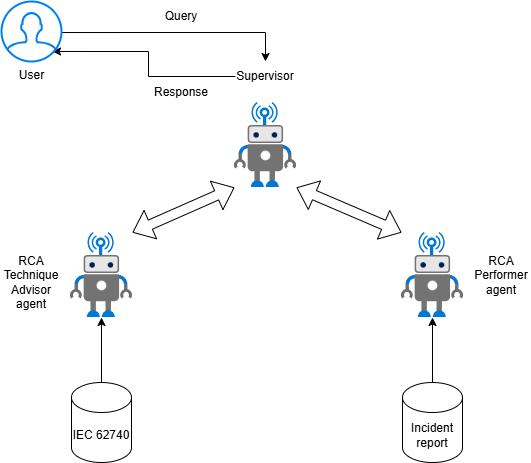

In [74]:
# Method 1: Using IPython.display (Recommended)
from IPython.display import Image, display
display(Image(filename='hackathon_architecture.png', width=800))

In [16]:
import os
from dotenv import load_dotenv
from openai import AzureOpenAI
from langchain_openai import AzureChatOpenAI
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent

from IPython.display import HTML, display
import pandas as pd
import markdown2

In [ ]:
# # Load environment variables from .env file
# load_dotenv()

# # Initialize the Azure OpenAI model
# client = AzureOpenAI(
#     azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
#     api_key=os.getenv("AZURE_OPENAI_API_KEY"),
#     api_version="2025-03-01-preview",
#     azure_deployment="gpt-4o-mini"
# )

In [ ]:
# def run_llm(prompt, client=client, model="gpt-4o-mini"):
#     try:
#         chat_completion = client.chat.completions.create(
#             messages=[
#                 {
#                     "role": "user",
#                     "content": prompt,
#                 }
#             ],
#             model=model,
#             # model="gpt-35-turbo-16k",
#             #model="gpt-4.1",
#             temperature=0,
#         )
#         llm_reply = chat_completion.choices[0].message.content
#         return llm_reply

#     except Exception as e:
#         print(f"An error occurred: {e}")
#         return e
    
# # text-embedding-ada-002

# prompt = "Hi, what is the capital of Netherlands?"

In [23]:
# run_llm(prompt)

In [10]:
# Update the client initialization cell
load_dotenv()

# Initialize the Azure OpenAI model with LangChain
llm = AzureChatOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    #model="gpt-4.1",
    azure_deployment=os.getenv("AZURE_DEPLOYMENT_NAME"),
    api_version="2025-03-01-preview",
    #temperature=0
)

In [3]:
print(os.getenv("AZURE_DEPLOYMENT_NAME"))

gpt-4.1


In [11]:
# Update the run_llm function cell
def run_llm(prompt):
    try:
        response = llm.invoke(prompt)
        return response.content 
    except Exception as e:
        print(f"An error occurred: {e}")
        return str(e)

In [12]:
ans=run_llm("What is the capital of France?")
print(ans)  # Should print "Paris" if the model is working correctly

The capital of France is **Paris**.


In [13]:
# Define the RCA Technique Advisor agent
technique_advisor_prompt = (
    "You are an expert in Root Cause Analysis (RCA) techniques. "
    "Given an incident description, suggest the most appropriate RCA technique "
    "(e.g., '5 Whys', 'Fishbone Diagram', 'Fault Tree Analysis') and briefly justify your choice."
)

technique_advisor = create_react_agent(
    model=llm,
    tools=[],
    name="rca_technique_advisor",
    prompt=technique_advisor_prompt
)

# Define the RCA Performer agent
rca_performer_prompt = (
    "You are an RCA specialist. Given an incident description and a recommended RCA technique, "
    "perform the analysis and provide the findings in a structured format."
)

rca_performer = create_react_agent(
    model=llm,
    tools=[],
    
    name="rca_performer",
    prompt=rca_performer_prompt
)

# Create the supervisor agent
supervisor_prompt = (
    "You are a supervisor managing two agents: 'rca_technique_advisor' and 'rca_performer'. "
    "First, delegate the incident description to 'rca_technique_advisor' to get the recommended RCA technique. "
    "Then, pass both the incident description and the recommended technique to 'rca_performer' to perform the analysis. "
    "Finally, compile and present the complete RCA findings."
)

supervisor = create_supervisor(
    agents=[technique_advisor, rca_performer],
    model=llm,
    prompt=supervisor_prompt
)



In [14]:
# Compile the supervisor into an executable application
app = supervisor.compile()

In [16]:
# Add a test cell
test_incident = "A production server experienced unexpected downtime during peak hours, affecting customer transactions."
result = app.invoke({"incident": test_incident})
print(result)

{'messages': [AIMessage(content='Please provide the incident description so I can begin the Root Cause Analysis process.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 151, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_3dfb47c1f3', 'id': 'chatcmpl-BRfMhc5b5Dr333DIhVffswFEjb86o', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, name='supervisor', id='run-f1b2fa28-53bd-4d5f-9a59-

In [17]:
# Define the incident description
incident_description = (
    "Gas leak during maintenance on Statfjord B when splitting a blind hub."
)

# Run the supervisor with the incident description
result = app.invoke({
    "messages": [
        {
            "role": "user",
            "content": incident_description
        }
    ]
})

# Display the results
for message in result["messages"]:
    # Access the properties using the correct attribute names
    print(f"{message.type.capitalize()}: {message.content}\n")

Human: Gas leak during maintenance on Statfjord B when splitting a blind hub.

Ai: 

Tool: Successfully transferred to rca_technique_advisor

Ai: Recommended RCA Technique: Fishbone Diagram (Ishikawa Diagram)

Justification: 
A gas leak during a maintenance procedure is a complex incident potentially involving multiple factors—procedures, equipment, human error, environment, and materials. The Fishbone Diagram is ideal for systematically exploring all possible causes in categories (e.g., Methods, Machines, People, Materials, Environment, Measurement), making it suitable for identifying contributing factors and underlying root causes in this maintenance-related incident.

Ai: Transferring back to supervisor

Tool: Successfully transferred back to supervisor

Ai: 

Tool: Successfully transferred to rca_performer

Ai: **Root Cause Analysis (RCA) using Fishbone (Ishikawa) Diagram**

**Incident Description:**  
Gas leak during maintenance on Statfjord B when splitting a blind hub.

---

**F

In [ ]:
def display_rca_flow_notebook(result):
    # Create HTML template with Bootstrap and custom CSS
    html = """
    <div style="max-width: 800px; margin: 20px auto;">
        <style>
            .card-body { padding: 15px; }
            .markdown-content { font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, "Helvetica Neue", Arial, sans-serif; }
            .markdown-content h1, h2, h3 { color: #2C3E50; margin-top: 20px; }
            .markdown-content pre { background-color: #f8f9fa; padding: 10px; border-radius: 4px; }
            .markdown-content ul, ol { padding-left: 20px; }
        </style>
        <h2 style="color: #2C3E50; text-align: center;">RCA Analysis Flow</h2>
        <div class="accordion" id="rcaAccordion">
    """
    
    # Add each message as an expandable card with Markdown rendering
    for i, msg in enumerate(result["messages"]):
        # Convert Markdown to HTML
        markdown_html = markdown2.markdown(msg.content)
        
        card_html = f"""
        <div class="card">
            <div class="card-header" style="background-color: #ECF0F1;">
                <button class="btn btn-link" type="button" data-toggle="collapse" 
                        data-target="#collapse{i}" style="color: #2C3E50;">
                    {msg.type.capitalize()} Message
                </button>
            </div>
            <div id="collapse{i}" class="collapse show">
                <div class="card-body">
                    <div class="markdown-content">
                        {markdown_html}
                    </div>
                </div>
            </div>
        </div>
        """
        html += card_html
    
    html += "</div></div>"
    
    # Display the HTML
    display(HTML(html))

# # Test the visualization
# incident_description = "Gas leak during maintenance on Statfjord B when splitting a blind hub."
# result = app.invoke({
#     "messages": [
#         {
#             "role": "user",
#             "content": incident_description
#         }
#     ]
# })

# Display the visualization
display_rca_flow_notebook(result)

## Enhance the knowledge base of the Technique advisor

In [17]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import AzureOpenAIEmbeddings
from langchain.tools import Tool

# Load and process the PDF
loader = PyPDFLoader("data\IEC-62740.pdf")  # Adjust filename as needed
documents = loader.load()

# Split into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)
chunks = text_splitter.split_documents(documents)

# Create embeddings and vector store
embeddings = AzureOpenAIEmbeddings(
    azure_endpoint=os.getenv("EMBEDDING_ENDPOINT"),
    api_key=os.getenv("EMBEDDING_API_KEY"),
    deployment=os.getenv("EMBEDDING_DEPLOYMENT"), #"text-embedding-ada-002"  # Update with your embedding model deployment
    api_version="2025-03-01-preview"
)

vectorstore = FAISS.from_documents(chunks, embeddings)

# Create a retrieval tool
def retrieve_rca_techniques(query: str) -> str:
    """Search for relevant RCA techniques in the knowledge base."""
    docs = vectorstore.similarity_search(query, k=3)
    return "\n\n".join(doc.page_content for doc in docs)

rca_knowledge_tool = Tool(
    name="rca_techniques_lookup",
    description="Search for industry standard RCA techniques and their applications",
    func=retrieve_rca_techniques
)

<>:8: SyntaxWarning: invalid escape sequence '\I'
<>:8: SyntaxWarning: invalid escape sequence '\I'
C:\Users\ABHANA\AppData\Local\Temp\ipykernel_2636\1830868649.py:8: SyntaxWarning: invalid escape sequence '\I'
  loader = PyPDFLoader("data\IEC-62740.pdf")  # Adjust filename as needed


In [18]:
# Update the RCA Technique Advisor agent
technique_advisor_prompt = """You are an expert in Root Cause Analysis (RCA) techniques.
Given an incident description:
1. Use the rca_techniques_lookup tool to search for relevant techniques
2. Consider the incident context and complexity
3. Suggest the most appropriate RCA technique
4. Justify your choice with reference to industry standards
5. Format your response in Markdown with clear headings

Current incident: {input}
"""

technique_advisor = create_react_agent(
    model=llm,
    tools=[rca_knowledge_tool],
    name="rca_technique_advisor",
    prompt=technique_advisor_prompt
)

In [19]:
# Define the RCA Performer agent
rca_performer_prompt = (
    "You are an RCA specialist. Given an incident description and a recommended RCA technique, "
    "perform the analysis and provide the findings in a structured format."
)

rca_performer = create_react_agent(
    model=llm,
    tools=[],
    name="rca_performer",
    prompt=rca_performer_prompt
)

# Create the supervisor agent
supervisor_prompt = (
    "You are a supervisor managing two agents: 'rca_technique_advisor' and 'rca_performer'. "
    "First, delegate the incident description to 'rca_technique_advisor' to get the recommended RCA technique. "
    "Then, pass both the incident description and the recommended technique to 'rca_performer' to perform the analysis. "
    "Finally, compile and present the complete RCA findings."
)

supervisor = create_supervisor(
    agents=[technique_advisor, rca_performer],
    model=llm,
    prompt=supervisor_prompt
)



In [20]:
# Compile the supervisor into an executable application
app = supervisor.compile()

In [22]:
# Define the incident description
incident_description = (
    "Gas leak during maintenance on Statfjord B when splitting a blind hub."
)

# Run the supervisor with the incident description
result = app.invoke({
    "messages": [
        {
            "role": "user",
            "content": incident_description
        }
    ]
})

# Display the results
for message in result["messages"]:
    # Access the properties using the correct attribute names
    print(f"{message.type.capitalize()}: {message.content}\n")

Human: Gas leak during maintenance on Statfjord B when splitting a blind hub.

Ai: 

Tool: Successfully transferred to rca_technique_advisor

Ai: # Recommended Root Cause Analysis Technique

## Incident Overview
**Incident:** Gas leak during maintenance on Statfjord B when splitting a blind hub.

## 1. Relevant RCA Techniques Identified

Based on the context of a gas leak during a maintenance operation in the oil and gas sector (specifically when splitting a blind hub), the following RCA references and frameworks are relevant:

- **IEC 62740:2015 - Root Cause Analysis (RCA):** This international standard defines the approaches and steps to perform systematic RCA, especially in high-risk technical industries.
- **Event & Causal Factor Charting (ECFC):** Used to map sequential events, actions, and conditions leading to incidents.
- **Cause-and-Effect (Fishbone/Ishikawa) Diagrams:** Identifies multiple root causes across different categories (people, process, equipment, environment).
- **

In [17]:
# Display the visualization
display_rca_flow_notebook(result)

In [23]:
def display_final_rca_response(result):
    # Create HTML template with Bootstrap and custom CSS
    html = """
    <div style="max-width: 800px; margin: 20px auto;">
        <style>
            .card-body { padding: 15px; }
            .markdown-content { font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, "Helvetica Neue", Arial, sans-serif; }
            .markdown-content h1, h2, h3 { color: #2C3E50; margin-top: 20px; }
            .markdown-content pre { background-color: #f8f9fa; padding: 10px; border-radius: 4px; }
            .markdown-content ul, ol { padding-left: 20px; }
        </style>
        <h2 style="color: #2C3E50; text-align: center;">RCA Analysis Results</h2>
    """
    
    # Get the last message (supervisor's final response)
    final_message = result["messages"][-1]
    
    # Convert Markdown to HTML
    markdown_html = markdown2.markdown(final_message.content)
    
    # Add the final response card
    card_html = f"""
    <div class="card">
        <div class="card-body">
            <div class="markdown-content">
                {markdown_html}
            </div>
        </div>
    </div>
    """
    
    html += card_html + "</div>"
    
    # Display the HTML
    display(HTML(html))

# # Test the visualization
# incident_description = "Gas leak during maintenance on Statfjord B when splitting a blind hub."
# result = app.invoke({
#     "messages": [
#         {
#             "role": "user",
#             "content": incident_description
#         }
#     ]
# })

# Display only the final response
display_final_rca_response(result)

## Providing RCA Performer access to investigation reports that are uploaded by user for further evidence (and context)

In [25]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.tools import Tool
from pathlib import Path
import tempfile

def process_investigation_report(file_path: str) -> str:
    """Process investigation report and extract relevant information."""
    try:
        loader = PyPDFLoader(file_path)
        pages = loader.load()
        return "\n\n".join(page.page_content for page in pages)
    except Exception as e:
        return f"Error processing report: {str(e)}"

investigation_tool = Tool(
    name="investigation_report_lookup",
    description="Search through investigation reports for relevant evidence and context",
    func=process_investigation_report
)

In [26]:
# Update the RCA Performer agent with evidence-based analysis
rca_performer_prompt = """You are an RCA specialist. Given an incident description and a recommended RCA technique:
1. Use the investigation_report_lookup tool to search for relevant evidence
2. Analyze the incident using the recommended technique and available evidence
3. Support your findings with specific references from the investigation reports
4. Present your analysis in a structured format with clear sections:
   - Incident Overview
   - Evidence Used
   - Analysis Process
   - Root Causes Identified
   - Supporting Evidence
   - Recommendations

Format your response in Markdown for better readability.
"""

rca_performer = create_react_agent(
    model=llm,
    tools=[investigation_tool],
    name="rca_performer",
    prompt=rca_performer_prompt
)

In [27]:
def analyze_incident_with_reports(incident_description: str, report_path: str):
    """
    Analyze an incident using available investigation reports.
    
    Args:
        incident_description: Description of the incident
        report_path: Path to the investigation report PDF
    """
    # # First, process all reports and store their content
    # all_evidence = []
    # for report_path in report_paths:
    #     evidence = process_investigation_report(report_path)
    #     all_evidence.append(evidence)
    
    evidence = process_investigation_report(report_path)

    # Compile the supervisor into an executable application
    app = supervisor.compile()
    
    # Run the analysis with the supervisor
    result = app.invoke({
        "messages": [
            {
                "role": "user",
                "content": incident_description
            }
        ],
        "context": {
            "investigation_reports": "\n\n===\n\n".join(evidence)
        }
    })
    
    # Display the final response with evidence-based analysis
    display_final_rca_response(result)
    return result

In [28]:
# Test the enhanced RCA system with investigation reports
incident_description = "A dropped object (a grating plate) on the Heidrun TLP, on 22 September 2015."
report_path = "data\investigation_reports\investigation-report---statoil---heidrun.pdf"
# report_paths = [
#     "data\investigation_reports\2022_1794-rapport-gransking-odfjell.pdf",
#     "data/investigation_reports/maintenance_logs.pdf"
# ]

result = analyze_incident_with_reports(incident_description, report_path)

<>:3: SyntaxWarning: invalid escape sequence '\i'
<>:3: SyntaxWarning: invalid escape sequence '\i'
C:\Users\ABHANA\AppData\Local\Temp\ipykernel_19080\510629113.py:3: SyntaxWarning: invalid escape sequence '\i'
  report_path = "data\investigation_reports\investigation-report---statoil---heidrun.pdf"


## Interview ability for RCA Performer agent if investigation reports are not available

In [37]:
from IPython.display import display
import ipywidgets as widgets
from typing import Union, Callable

In [34]:
# Update the RCA Performer prompt to handle interview evidence
rca_performer_prompt = """You are an RCA specialist. Given an incident description and a recommended RCA technique:
1. If interview evidence is available, use it to inform your analysis
2. If investigation reports are available, use them as evidence
3. Analyze the incident using the recommended technique and available evidence
4. Present your analysis in a structured format with clear sections:
   - Incident Overview
   - Evidence Used
   - Analysis Process
   - Root Causes Identified
   - Supporting Evidence
   - Recommendations

Format your response in Markdown for better readability.
"""

In [35]:
# Compile the supervisor into an executable application
app = supervisor.compile()

In [38]:
def interactive_interview(incident_description: str, on_complete: Callable[[dict], None]):
    """Conduct an interactive interview and call on_complete when done."""
    import ipywidgets as widgets
    from IPython.display import display
    import time

    questions = {
        "maintenance": [
            "What maintenance procedures were being followed?",
            "Who was involved in the maintenance activity?",
            "What safety measures were in place?",
            "Were there any similar incidents in the past?"
        ],
        "equipment_failure": [
            "What was the equipment's maintenance history?",
            "When was the last inspection?",
            "Were there any warning signs before the failure?",
            "What were the operating conditions at the time?"
        ]
    }

    question_set = "maintenance" if "maintenance" in incident_description.lower() else "equipment_failure"
    questions_list = questions[question_set]

    state = {
        "current_q_idx": 0,
        "responses": {}
    }

    question_label = widgets.HTML(f"<h3>Q: {questions_list[0]}</h3>")
    answer_box = widgets.Textarea(placeholder='Type your answer here...', layout=widgets.Layout(width='100%', height='100px'))
    next_button = widgets.Button(description='Next Question', button_style='primary')
    progress = widgets.HTML(value=f"Question 1 of {len(questions_list)}")
    status = widgets.Output()

    def on_next_clicked(_):
        current_q = questions_list[state["current_q_idx"]]
        state["responses"][current_q] = answer_box.value

        state["current_q_idx"] += 1

        if state["current_q_idx"] < len(questions_list):
            question_label.value = f"<h3>Q: {questions_list[state['current_q_idx']]}</h3>"
            progress.value = f"Question {state['current_q_idx'] + 1} of {len(questions_list)}"
            answer_box.value = ""
            if state["current_q_idx"] == len(questions_list) - 1:
                next_button.description = "Finish"
        else:
            container.close()
            on_complete(state["responses"])

    next_button.on_click(on_next_clicked)

    container = widgets.VBox([
        widgets.HTML(f"<h2>RCA Interview</h2><p>Incident: {incident_description}</p>"),
        progress,
        question_label,
        answer_box,
        next_button,
        status
    ])
    display(container)


In [40]:
def analyze_incident(incident_description: str, report_path: Union[str, None] = None):
    """Analyze incident using either investigation reports or interactive interview."""
    from IPython.display import display
    import ipywidgets as widgets
    import os

    print("\n=== Starting RCA Analysis ===")

    loading = widgets.HTML("<b>Analyzing... please wait.</b> <i class='fa fa-spinner fa-spin'></i>")
    messages = [{"role": "user", "content": incident_description}]
    context = {}

    if report_path and os.path.exists(report_path):
        print("Using investigation report for analysis...")
        evidence = process_investigation_report(report_path)
        context["evidence_type"] = "report"
        context["evidence"] = evidence

        display(loading)
        result = app.invoke({
            "messages": messages,
            "context": context
        })
        loading.value = ""  # Stop spinner
        print("\n=== Analysis Results ===")
        display_final_rca_response(result)

    else:
        print("No investigation report found. Starting interactive interview...")

        def on_complete(responses):
            evidence = "\n\n".join([f"Q: {q}\nA: {a}" for q, a in responses.items()])
            context["evidence_type"] = "interview"
            context["evidence"] = evidence

            display(loading)
            result = app.invoke({
                "messages": messages,
                "context": context
            })
            loading.value = ""  # Stop spinner
            print("\n=== Analysis Results ===")
            display_final_rca_response(result)

        interactive_interview(incident_description, on_complete)


In [41]:
# Test the interactive analysis
incident = "A dropped object (a grating plate) on the Heidrun TLP, on 22 September 2015."
result = analyze_incident(incident)  # This will trigger the interview


=== Starting RCA Analysis ===
No investigation report found. Starting interactive interview...


HTML(value="<b>Analyzing... please wait.</b> <i class='fa fa-spinner fa-spin'></i>")